# Identificación de duplicados region de LOS LAGOS

### Librerías

In [3]:
# Instalar fuzzywuzzy y scikit-learn si no están instalados
#!pip install fuzzywuzzy[speedup]
#!pip install scikit-learn

# Importar las bibliotecas necesarias
import pandas as pd
import re
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [62]:
data_loslagos = pd.read_csv('sub_data_LOS LAGOS.csv')

In [63]:
# Eliminar las columnas 'Unnamed: 0' y 'Unnamed..0' del DataFrame
data_loslagos.drop(['Unnamed: 0', 'Unnamed..0'], axis=1, inplace=True)

# Verificar que las columnas han sido eliminadas
print(data_loslagos.columns)


Index(['id', 'concat', 'publicada', 'created_at', 'data_source', 'tipo',
       'sub_tipo', 'precio_clp', 'precio_uf', 'region', 'comuna', 'latitude',
       'longitude', 'total_o_terreno', 'util_o_construido', 'active',
       'fecha_finalizacion', 'precio_clp_inicial', 'precio_uf_inicial',
       'descripcion_sin_saltos', 'direccion_sin_saltos', 'descripcion_2',
       'region_norm', 'comuna_norm', 'comuna_match', 'superficies_dict',
       'mayor_superficie', 'diferencia_pct', 'diferencia_abs', 'dif_pct_abs',
       'descripcion_normalizada', 'duplicados_con'],
      dtype='object')


In [64]:
# Convertir la columna 'id' a enteros (si aplica)
data_loslagos['id'] = data_loslagos['id'].astype('Int64')

### Procesamiento de texto

In [65]:
import re

# Modificar la función de preprocesamiento para manejar NaN
def preprocesar_texto(texto):
    if pd.isna(texto):
        return ''
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = ' '.join(texto.split())
    return texto

# Crear una copia del DataFrame para evitar la advertencia
data_loslagos = data_loslagos.copy()

# Aplicar el preprocesamiento a la columna de descripciones
data_loslagos['descripcion_normalizada'] = data_loslagos['descripcion_sin_saltos'].apply(preprocesar_texto)

# Ver los primeros resultados para verificar el preprocesamiento
print(data_loslagos[['descripcion_sin_saltos', 'descripcion_normalizada']].head())

                              descripcion_sin_saltos  \
0  Planning Patagonia vende lindo loteo entre Pla...   
1  Se vende sitio para inversión, UF 10 m2, posib...   
2  Planning Frutillar vende exclusivo loteo entre...   
3                                                NaN   
4  Se vende ùltimas parcela, lote 15 de un lote d...   

                             descripcion_normalizada  
0  planning patagonia vende lindo loteo entre pla...  
1  se vende sitio para inversión uf 10 m2 posibil...  
2  planning frutillar vende exclusivo loteo entre...  
3                                                     
4  se vende ùltimas parcela lote 15 de un lote de...  


### Calcular la matriz TF-IDF para las descripciones

In [36]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Supongamos que ya tienes los textos normalizados en 'descripcion_normalizada'
# y que el DataFrame es 'data_loslagos'

# Convertir la columna 'id' a enteros (si aplica)
data_loslagos['id'] = data_loslagos['id'].astype('Int64')

# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# Transformar las descripciones normalizadas en una matriz TF-IDF
tfidf_matrix = vectorizer.fit_transform(data_loslagos['descripcion_normalizada'])

# Ver el tamaño de la matriz TF-IDF para comprobar el resultado
print(f"Tamaño de la matriz TF-IDF: {tfidf_matrix.shape}")

# Definir el tamaño del lote
batch_size = 1000  # Puedes ajustar este valor según los recursos de tu sistema

# Definir el umbral de similaridad
umbral = 0.85

# Crear una lista para almacenar los pares duplicados
duplicados = []

# Número total de documentos
num_rows = tfidf_matrix.shape[0]

# Crear una nueva columna en el DataFrame para almacenar los IDs duplicados
data_loslagos['duplicados_con'] = [[] for _ in range(len(data_loslagos))]

# Procesar en lotes
for start in range(0, num_rows, batch_size):
    end = min(start + batch_size, num_rows)
    batch_matrix = tfidf_matrix[start:end]

    # Calcular la similaridad coseno entre el lote y la matriz completa
    similaridad_batch = cosine_similarity(batch_matrix, tfidf_matrix)

    # Encontrar duplicados dentro del lote
    for i in range(similaridad_batch.shape[0]):
        for j in range(similaridad_batch.shape[1]):
            # Evitar comparar una fila consigo misma y evitar duplicados repetidos
            if i != j and similaridad_batch[i, j] > umbral:
                id_1 = data_loslagos.iloc[start + i]['id']
                id_2 = data_loslagos.iloc[j]['id']

                # Verificar que el duplicado aún no está en la lista de duplicados
                if id_2 not in data_loslagos.at[start + i, 'duplicados_con']:
                    duplicados.append((id_1, id_2))

                    # Agregar el id_2 a la lista de duplicados de id_1
                    data_loslagos.at[start + i, 'duplicados_con'].append(id_2)
                
                # Verificar que el id_1 no se agregue dos veces en la lista de id_2
                if id_1 not in data_loslagos.at[j, 'duplicados_con']:
                    # Agregar el id_1 a la lista de duplicados de id_2
                    data_loslagos.at[j, 'duplicados_con'].append(id_1)

# Eliminar duplicados en las listas de duplicados
data_loslagos['duplicados_con'] = data_loslagos['duplicados_con'].apply(lambda x: list(set(x)))

# Mostrar los pares de duplicados encontrados
print(f"Pares de duplicados encontrados: {len(duplicados)}")
for dup in duplicados:
    print(f"Duplicado entre id {dup[0]} y id {dup[1]}")

# Marcar los registros duplicados en la columna 'duplicado'
data_loslagos['duplicado'] = data_loslagos['duplicados_con'].apply(lambda x: len(x) > 0)

# Mostrar los registros identificados como duplicados
duplicados_identificados = data_loslagos[data_loslagos['duplicado'] == True]
print(duplicados_identificados[['id', 'duplicados_con']])

# Guardar los duplicados identificados en un archivo CSV (opcional)
duplicados_identificados.to_csv('duplicados_los_lagos.csv', index=False)

'''

Tamaño de la matriz TF-IDF: (55638, 83189)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Duplicado entre id 7564196 y id 7881134
Duplicado entre id 7564196 y id 7881135
Duplicado entre id 7564196 y id 7881136
Duplicado entre id 7564196 y id 7892864
Duplicado entre id 7564196 y id 7893049
Duplicado entre id 7564196 y id 7956220
Duplicado entre id 7564196 y id 7956222
Duplicado entre id 7564196 y id 8005752
Duplicado entre id 7564196 y id 8005754
Duplicado entre id 7564196 y id 8006119
Duplicado entre id 7564196 y id 8023437
Duplicado entre id 7564196 y id 8023438
Duplicado entre id 7564196 y id 8023476
Duplicado entre id 7564196 y id 8023487
Duplicado entre id 7564196 y id 8029183
Duplicado entre id 7564196 y id 8029292
Duplicado entre id 7564196 y id 8029376
Duplicado entre id 7564196 y id 8029377
Duplicado entre id 7564225 y id 7564225
Duplicado entre id 7564225 y id 7611592
Duplicado entre id 7564225 y id 7636854
Duplicado entre id 7564225 y id 7643431
Duplicado entre id 7564225 y id 7676443
Duplicado entre id 7564225 y id 7706715
Duplicado entre id 7564225 y id 7733946


In [66]:
# Convertir todas las columnas numéricas que no tienen parte decimal a enteros usando .loc[]
for col in data_loslagos.select_dtypes(include=['float']).columns:
    if (data_loslagos[col] % 1 == 0).all():  # Verifica si no hay decimales
        data_loslagos.loc[:, col] = data_loslagos[col].astype('Int64')

# Exportar el DataFrame a CSV
# duplicados_identificados.to_csv('data_los_lagos.csv', index=False)



### Transformación y agrupación por semestre

In [68]:
import pandas as pd

# Convertir la columna 'publicada' a formato datetime si no lo está ya
data_loslagos['publicada'] = pd.to_datetime(data_loslagos['publicada'], errors='coerce')

# Crear una nueva columna que agrupe por semestres
data_loslagos['semestre'] = data_loslagos['publicada'].dt.year.astype(str) + "S" + ((data_loslagos['publicada'].dt.month - 1) // 6 + 1).astype(str)

# Verificar los semestres creados
print(data_loslagos[['publicada', 'semestre']].head())

# Ahora tienes los datos agrupados por semestres en la columna 'semestre'


   publicada semestre
0 2021-01-14   2021S1
1 2021-01-14   2021S1
2 2021-01-14   2021S1
3 2021-02-23   2021S1
4 2021-01-14   2021S1


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Filtrar las filas que son de enero de 2021 en adelante
data_loslagos['publicada'] = pd.to_datetime(data_loslagos['publicada'], errors='coerce')  # Asegurarse de que sea tipo datetime
data_loslagos = data_loslagos[data_loslagos['publicada'] >= '2021-01-01']

# Definir el umbral de similaridad
umbral = 0.85

# Crear una lista para almacenar los pares duplicados
duplicados = []

# Crear una nueva columna en el DataFrame para almacenar los IDs duplicados
data_loslagos['duplicados_con'] = [[] for _ in range(len(data_loslagos))]

# Agrupar el DataFrame por semestre y procesar duplicados en cada semestre
for semestre, grupo in data_loslagos.groupby('semestre'):
    print(f"Procesando duplicados para el semestre: {semestre}")
    
    # Crear el vectorizador TF-IDF para el grupo
    vectorizer = TfidfVectorizer()

    # Transformar las descripciones normalizadas del grupo en una matriz TF-IDF
    tfidf_matrix = vectorizer.fit_transform(grupo['descripcion_normalizada'])

    # Ver el tamaño de la matriz TF-IDF para el grupo
    print(f"Tamaño de la matriz TF-IDF para el semestre {semestre}: {tfidf_matrix.shape}")

    # Calcular la similaridad coseno para el grupo
    similaridad_coseno = cosine_similarity(tfidf_matrix)

    # Encontrar duplicados dentro del semestre
    for i in range(similaridad_coseno.shape[0]):
        for j in range(similaridad_coseno.shape[1]):
            # Evitar comparar una fila consigo misma y evitar duplicados repetidos
            if i != j and similaridad_coseno[i, j] > umbral:
                id_1 = grupo.iloc[i]['id']
                id_2 = grupo.iloc[j]['id']

                # Verificar que el duplicado aún no está en la lista de duplicados
                if id_2 not in grupo.iloc[i]['duplicados_con']:
                    duplicados.append((id_1, id_2))

                    # Agregar el id_2 a la lista de duplicados de id_1
                    grupo.at[grupo.index[i], 'duplicados_con'].append(id_2)
                
                # Verificar que el id_1 no se agregue dos veces en la lista de id_2
                if id_1 not in grupo.iloc[j]['duplicados_con']:
                    # Agregar el id_1 a la lista de duplicados de id_2
                    grupo.at[grupo.index[j], 'duplicados_con'].append(id_1)
    
    # Actualizar el DataFrame principal con los duplicados encontrados en el grupo
    data_loslagos.update(grupo)

# Eliminar duplicados en las listas de duplicados
data_loslagos['duplicados_con'] = data_loslagos['duplicados_con'].apply(lambda x: list(set(x)))

# Mostrar los pares de duplicados encontrados
print(f"Pares de duplicados encontrados: {len(duplicados)}")
for dup in duplicados:
    print(f"Duplicado entre id {dup[0]} y id {dup[1]}")

# Marcar los registros duplicados en la columna 'duplicado'
data_loslagos['duplicado'] = data_loslagos['duplicados_con'].apply(lambda x: len(x) > 0)

# Mostrar los registros identificados como duplicados
#duplicados_identificados = data_loslagos[data_loslagos['duplicado'] == True]
#print(duplicados_identificados[['id', 'duplicados_con']])

# Guardar los duplicados identificados en un archivo CSV (opcional)
#duplicados_identificados.to_csv('duplicados_los_lagos.csv', index=False)


Procesando duplicados para el semestre: 2021S1
Tamaño de la matriz TF-IDF para el semestre 2021S1: (5604, 19890)
Procesando duplicados para el semestre: 2021S2
Tamaño de la matriz TF-IDF para el semestre 2021S2: (5656, 20012)
Procesando duplicados para el semestre: 2022S1
Tamaño de la matriz TF-IDF para el semestre 2022S1: (6703, 20817)
Procesando duplicados para el semestre: 2022S2
Tamaño de la matriz TF-IDF para el semestre 2022S2: (12669, 27109)
Procesando duplicados para el semestre: 2023S1
Tamaño de la matriz TF-IDF para el semestre 2023S1: (7375, 22793)
Procesando duplicados para el semestre: 2023S2
Tamaño de la matriz TF-IDF para el semestre 2023S2: (4835, 19059)
Procesando duplicados para el semestre: 2024S1
Tamaño de la matriz TF-IDF para el semestre 2024S1: (9577, 29692)
Procesando duplicados para el semestre: 2024S2
Tamaño de la matriz TF-IDF para el semestre 2024S2: (2391, 13339)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Duplicado entre id 7564788 y id 7682370
Duplicado entre id 7564791 y id 7578557
Duplicado entre id 7564791 y id 7592439
Duplicado entre id 7564791 y id 7617973
Duplicado entre id 7564791 y id 7643908
Duplicado entre id 7564791 y id 7659256
Duplicado entre id 7564791 y id 7661778
Duplicado entre id 7564791 y id 7670777
Duplicado entre id 7564791 y id 7682467
Duplicado entre id 7564793 y id 7576186
Duplicado entre id 7564794 y id 7618011
Duplicado entre id 7564794 y id 7670767
Duplicado entre id 7564795 y id 7572470
Duplicado entre id 7564795 y id 7617961
Duplicado entre id 7564795 y id 7617972
Duplicado entre id 7564795 y id 7617977
Duplicado entre id 7564795 y id 7627785
Duplicado entre id 7564795 y id 7670789
Duplicado entre id 7564795 y id 7670792
Duplicado entre id 7564795 y id 7670796
Duplicado entre id 7564795 y id 7676909
Duplicado entre id 7564795 y id 7688222
Duplicado entre id 7564795 y id 7688228
Duplicado entre id 7564795 y id 7688234
Duplicado entre id 7564795 y id 7693978


<Figure size 1000x600 with 0 Axes>

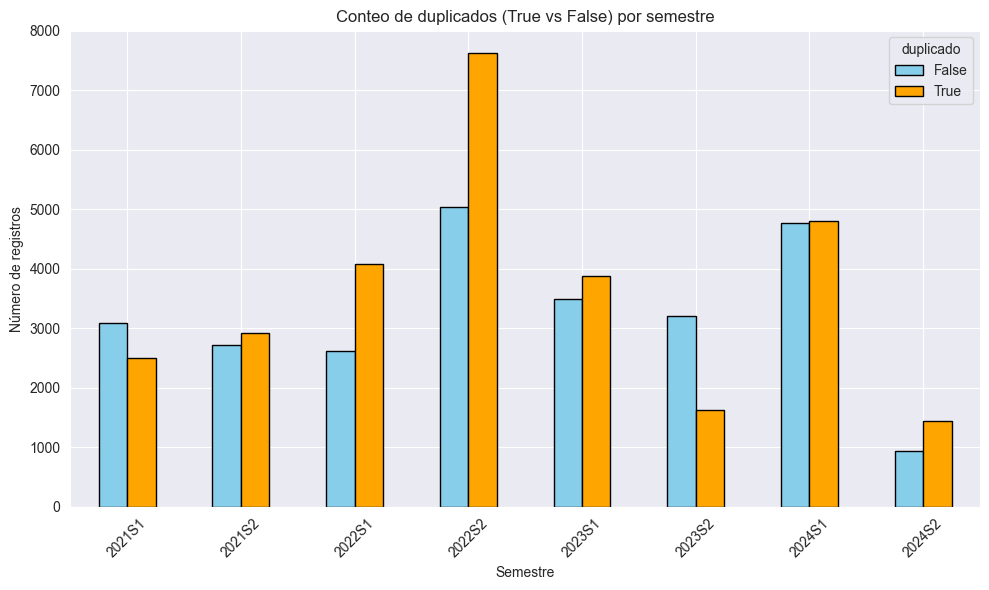

In [70]:
import matplotlib.pyplot as plt

# Contar cuántas filas tienen duplicados (True/False) por semestre
conteo_duplicados_por_semestre = data_loslagos.groupby(['semestre', 'duplicado']).size().unstack(fill_value=0)

# Crear un gráfico de barras agrupadas (sin apilar)
plt.figure(figsize=(10, 6))
conteo_duplicados_por_semestre.plot(kind='bar', stacked=False, color=['skyblue', 'orange'], edgecolor='black', figsize=(10, 6))

# Añadir etiquetas y título
plt.title('Conteo de duplicados (True vs False) por semestre')
plt.xlabel('Semestre')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)  # Rotar etiquetas de los semestres

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el diseño para evitar que los textos se solapen
plt.show()


In [76]:
# Contar cuántos registros son duplicados y cuántos no en toda la región de Los Lagos
conteo_total = data_loslagos['duplicado'].value_counts()

# Mostrar el conteo total
print("Conteo total de duplicados y no duplicados en la Región de Los Lagos:")
print(conteo_total)

Conteo total de duplicados y no duplicados en la Región de Los Lagos:
duplicado
True     28903
False    25907
Name: count, dtype: int64


In [77]:
# Contar cuántos registros son duplicados y cuántos no por cada semestre
conteo_por_semestre = data_loslagos.groupby('semestre')['duplicado'].value_counts()

# Mostrar el conteo por semestre
print("Conteo de duplicados y no duplicados por semestre en la Región de Los Lagos:")
print(conteo_por_semestre)


Conteo de duplicados y no duplicados por semestre en la Región de Los Lagos:
semestre  duplicado
2021S1    False        3098
          True         2506
2021S2    True         2928
          False        2728
2022S1    True         4085
          False        2618
2022S2    True         7628
          False        5041
2023S1    True         3885
          False        3490
2023S2    False        3213
          True         1622
2024S1    True         4798
          False        4779
2024S2    True         1451
          False         940
Name: count, dtype: int64


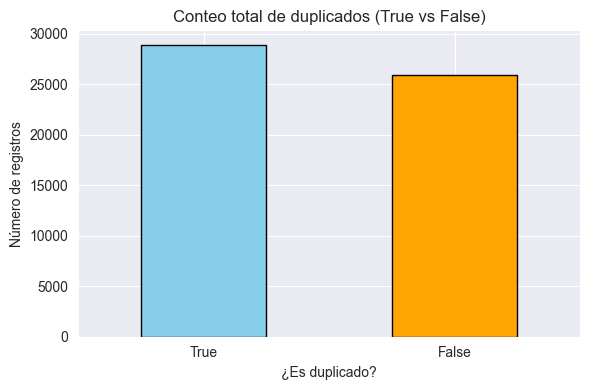

In [81]:
import matplotlib.pyplot as plt

# Contar cuántos registros tienen duplicados (True/False)
conteo_duplicados_total = data_loslagos['duplicado'].value_counts()

# Crear un gráfico de barras para el conteo total de duplicados (True vs False)
plt.figure(figsize=(6, 4))
conteo_duplicados_total.plot(kind='bar', color=['skyblue', 'orange'], edgecolor='black')

# Añadir etiquetas y título
plt.title('Conteo total de duplicados (True vs False)')
plt.xlabel('¿Es duplicado?')
plt.ylabel('Número de registros')
plt.xticks(rotation=0)  # Mantener las etiquetas horizontales

# Mostrar el gráfico
plt.tight_layout()
plt.show()



In [71]:
# Identificar las columnas que son de tipo float y convertirlas a enteros si no tienen parte decimal
for col in data_loslagos.select_dtypes(include=['float']).columns:
    if (data_loslagos[col] % 1 == 0).all():  # Si la columna no tiene parte decimal
        data_loslagos.loc[:, col] = data_loslagos[col].astype('Int64')  # Usar loc para evitar la advertencia

# Exportar a CSV sin índice
data_loslagos.to_csv('data_loslagos.csv', index=False)


In [72]:
# Lista de IDs que quieres verificar
ids_a_verificar = [1486758, 890667, 1480876, 1425197, 1182894, 1175278, 1546077, 342824]

# Filtrar el DataFrame por los IDs que quieres ver y mostrar las columnas 'id' y 'mayor_superficie'
resultados = data_loslagos.loc[data_loslagos['id'].isin(ids_a_verificar), ['id', 'mayor_superficie']]

# Mostrar los resultados
print(resultados)


           id  mayor_superficie
142    342824          450000.0
1184   890667          450000.0
2495  1175278          450000.0
2537  1182894          450000.0
4819  1425197          450000.0
5445  1480876          450000.0
5518  1486758          450000.0
6563  1546077          450000.0


# Duplicados Data completa

### Importar Data y limpiarla

In [83]:
import warnings

# Ocultar solo los DtypeWarnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

# Leer el CSV
data_lares = pd.read_csv('data_lares.csv')


In [84]:
# Eliminar las columnas 'Unnamed: 0' y 'Unnamed..0' del DataFrame
data_lares.drop(['Unnamed: 0', 'Unnamed..0'], axis=1, inplace=True)

# Verificar que las columnas han sido eliminadas
print(data_lares.columns)

Index(['id', 'concat', 'publicada', 'created_at', 'data_source', 'tipo',
       'sub_tipo', 'precio_clp', 'precio_uf', 'region', 'comuna', 'latitude',
       'longitude', 'total_o_terreno', 'util_o_construido', 'active',
       'fecha_finalizacion', 'precio_clp_inicial', 'precio_uf_inicial',
       'descripcion_sin_saltos', 'direccion_sin_saltos', 'descripcion_2',
       'region_norm', 'comuna_norm', 'comuna_match', 'superficies_dict',
       'mayor_superficie', 'diferencia_pct', 'diferencia_abs', 'dif_pct_abs'],
      dtype='object')


In [85]:
# Convertir la columna 'id' a enteros (si aplica)
data_lares['id'] = data_lares['id'].astype('Int64')

In [86]:
# Convertir la columna 'publicada' a formato datetime en data_lares
data_lares['publicada'] = pd.to_datetime(data_lares['publicada'], errors='coerce')

# Crear una nueva columna que agrupe por semestres
data_lares['semestre'] = data_lares['publicada'].dt.year.astype(str) + "S" + ((data_lares['publicada'].dt.month - 1) // 6 + 1).astype(str)

# Verificar los semestres creados
print(data_lares[['publicada', 'semestre']].head())


   publicada semestre
0 2021-01-14   2021S1
1 2024-04-27   2024S1
2 2021-02-23   2021S1
3 2023-11-02   2023S2
4 2021-09-28   2021S2


### Procesamiento de texto

In [87]:
import re
import pandas as pd

# Modificar la función de preprocesamiento para manejar NaN
def preprocesar_texto(texto):
    if pd.isna(texto):
        return ''
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = ' '.join(texto.split())  # Eliminar espacios en blanco adicionales
    return texto

# Aplicar el preprocesamiento a la columna de descripciones en data_lares
data_lares['descripcion_normalizada'] = data_lares['descripcion_sin_saltos'].apply(preprocesar_texto)

# Verificar los primeros resultados
print(data_lares[['descripcion_sin_saltos', 'descripcion_normalizada']].head())


                              descripcion_sin_saltos  \
0  Planning Patagonia vende lindo loteo entre Pla...   
1  Parcela de 3 hectáreas, dividida en 5 lotes, c...   
2  UBICACIÓNPropiedad ubicada en la comuna de Vic...   
3                                                NaN   
4  INVERSIONISTAS INMOBILIARIOS Ficha de Venta lo...   

                             descripcion_normalizada  
0  planning patagonia vende lindo loteo entre pla...  
1  parcela de 3 hectáreas dividida en 5 lotes cas...  
2  ubicaciónpropiedad ubicada en la comuna de vic...  
3                                                     
4  inversionistas inmobiliarios ficha de venta lo...  


### Detección de duplicados por región y semestre con vectorización TD-IDF y la similaridad coseno

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Filtrar las filas que son de enero de 2021 en adelante
data_lares = data_lares[data_lares['publicada'] >= '2021-01-01']

# Asegurarse de que la columna 'duplicados_con' existe en el DataFrame
data_lares['duplicados_con'] = [[] for _ in range(len(data_lares))]  # Crear la columna vacía

# Definir el umbral de similaridad
umbral = 0.85

# Crear una lista para almacenar los resultados de duplicados de todas las regiones
duplicados_totales = []

# Recorrer cada región
for region, grupo_region in data_lares.groupby('region'):
    print(f"Procesando duplicados para la región: {region}")
    
    # Recorrer cada semestre dentro de la región
    for semestre, grupo_semestre in grupo_region.groupby('semestre'):
        print(f"Procesando duplicados para el semestre: {semestre} en la región {region}")

        # Asegurarse de que el grupo tiene al menos 2 filas para hacer comparaciones
        if len(grupo_semestre) < 2:
            continue

        # Crear el vectorizador TF-IDF para las descripciones normalizadas del grupo por semestre
        vectorizer = TfidfVectorizer()

        # Transformar las descripciones normalizadas en una matriz TF-IDF
        tfidf_matrix = vectorizer.fit_transform(grupo_semestre['descripcion_normalizada'])

        # Calcular la similaridad coseno para las descripciones del grupo
        similaridad_coseno = cosine_similarity(tfidf_matrix)

        # Crear una columna 'duplicados_con' vacía para almacenar los IDs duplicados dentro del semestre
        grupo_semestre['duplicados_con'] = [[] for _ in range(len(grupo_semestre))]

        # Encontrar duplicados dentro del semestre
        duplicados_region = []
        for i in range(similaridad_coseno.shape[0]):
            for j in range(similaridad_coseno.shape[1]):
                # Evitar comparar una fila consigo misma y evitar duplicados repetidos
                if i != j and similaridad_coseno[i, j] > umbral:
                    id_1 = grupo_semestre.iloc[i]['id']
                    id_2 = grupo_semestre.iloc[j]['id']

                    # Verificar que el duplicado aún no está en la lista de duplicados
                    if id_2 not in grupo_semestre.iloc[i]['duplicados_con']:
                        duplicados_region.append((id_1, id_2))
                        grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con'].append(id_2)
                    
                    if id_1 not in grupo_semestre.iloc[j]['duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con'].append(id_1)

        # Guardar los duplicados encontrados para este semestre dentro de la región
        duplicados_totales.extend(duplicados_region)

        # Actualizar el DataFrame principal con los duplicados encontrados en el grupo por semestre
        data_lares.update(grupo_semestre)

# Eliminar duplicados en las listas de duplicados
data_lares['duplicados_con'] = data_lares['duplicados_con'].apply(lambda x: list(set(x)))

# Marcar los registros duplicados en la columna 'duplicado'
data_lares['duplicado'] = data_lares['duplicados_con'].apply(lambda x: len(x) > 0)

# Mostrar los pares de duplicados encontrados en todas las regiones y semestres
print(f"Pares de duplicados encontrados en todas las regiones y semestres: {len(duplicados_totales)}")
for dup in duplicados_totales:
    print(f"Duplicado entre id {dup[0]} y id {dup[1]}")


# Guardar los duplicados identificados en un archivo CSV (opcional)
# duplicados_identificados = data_lares[data_lares['duplicado'] == True]
# duplicados_identificados.to_csv('duplicados_todas_regiones_semestres.csv', index=False)


Procesando duplicados para la región: ANTOFAGASTA
Procesando duplicados para el semestre: 2021S1 en la región ANTOFAGASTA
Procesando duplicados para el semestre: 2021S2 en la región ANTOFAGASTA
Procesando duplicados para el semestre: 2022S1 en la región ANTOFAGASTA
Procesando duplicados para el semestre: 2022S2 en la región ANTOFAGASTA
Procesando duplicados para el semestre: 2023S1 en la región ANTOFAGASTA
Procesando duplicados para el semestre: 2023S2 en la región ANTOFAGASTA
Procesando duplicados para el semestre: 2024S1 en la región ANTOFAGASTA
Procesando duplicados para el semestre: 2024S2 en la región ANTOFAGASTA
Procesando duplicados para la región: ARAUCANIA
Procesando duplicados para el semestre: 2021S1 en la región ARAUCANIA
Procesando duplicados para el semestre: 2021S2 en la región ARAUCANIA
Procesando duplicados para el semestre: 2022S1 en la región ARAUCANIA
Procesando duplicados para el semestre: 2022S2 en la región ARAUCANIA
Procesando duplicados para el semestre: 2023S1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [90]:
# Guardar la data procesada en un archivo CSV
data_lares.to_csv('data_lares_con_duplicados.csv', index=False)


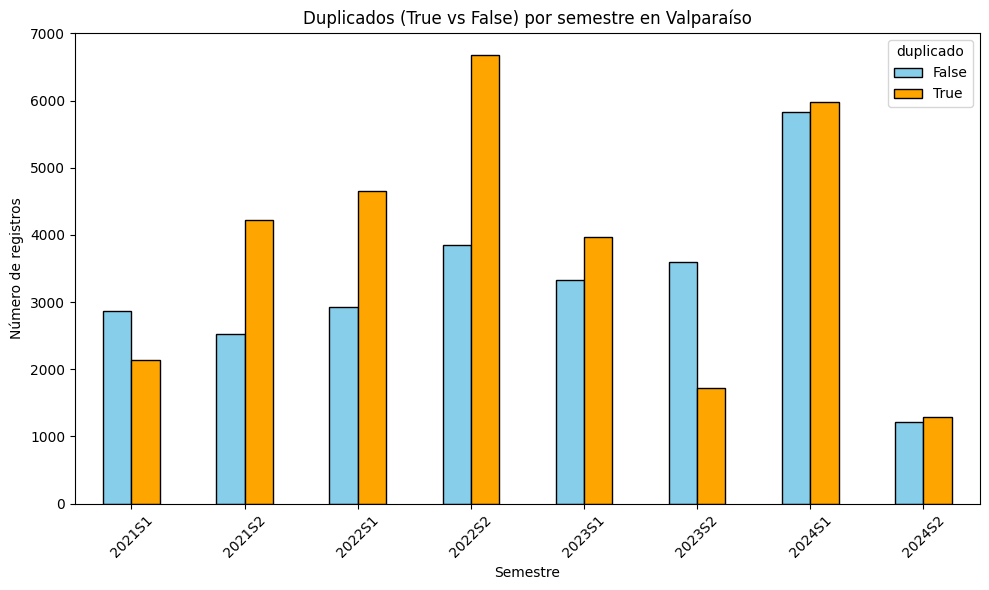

In [45]:
import matplotlib.pyplot as plt

# 1. Filtrar los datos para la región de Valparaíso
data_valparaiso = data_lares[data_lares['region'] == 'VALPARAISO']

# 2. Contar cuántos duplicados hay por semestre (True/False)
conteo_duplicados_valparaiso = data_valparaiso.groupby(['semestre', 'duplicado']).size().unstack(fill_value=0)

# 3. Realizar el gráfico de barras agrupadas (True y False por semestre)
conteo_duplicados_valparaiso.plot(kind='bar', stacked=False, color=['skyblue', 'orange'], edgecolor='black', figsize=(10, 6))

# Añadir etiquetas y título
plt.title('Duplicados (True vs False) por semestre en Valparaíso')
plt.xlabel('Semestre')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)  # Rotar etiquetas de los semestres

# Mostrar el gráfico
plt.tight_layout()


In [95]:
# Convertir las columnas numéricas de tipo float a enteros si no tienen parte decimal
for col in data_lares.select_dtypes(include=['float']).columns:
    if (data_lares[col] % 1 == 0).all():  # Verificar si todos los valores son enteros
        data_lares[col] = data_lares[col].astype('Int64')  # Convertir a enteros, respetando valores NaN

# Guardar el DataFrame en un archivo CSV
data_lares.to_csv('data_lares_con_duplicados.csv', index=False)


In [98]:
# Lista de IDs que quieres verificar
ids_a_verificar = [181544, 4402848,201438]

# Filtrar el DataFrame por los IDs que quieres ver y mostrar las columnas 'id' y 'mayor_superficie'
resultados = data_lares.loc[data_lares['id'].isin(ids_a_verificar), ['id', 'mayor_superficie', 'superficies_dict']]

# Mostrar los resultados
print(resultados)

             id  mayor_superficie  \
497      181544          600000.0   
789      201438          600000.0   
152980  4402848          600000.0   

                                         superficies_dict  
497     {'superficie_1': 600000.0, 'superficie_2': 400...  
789     {'superficie_1': 600000.0, 'superficie_2': 400...  
152980  {'superficie_1': 600000.0, 'superficie_2': 400...  


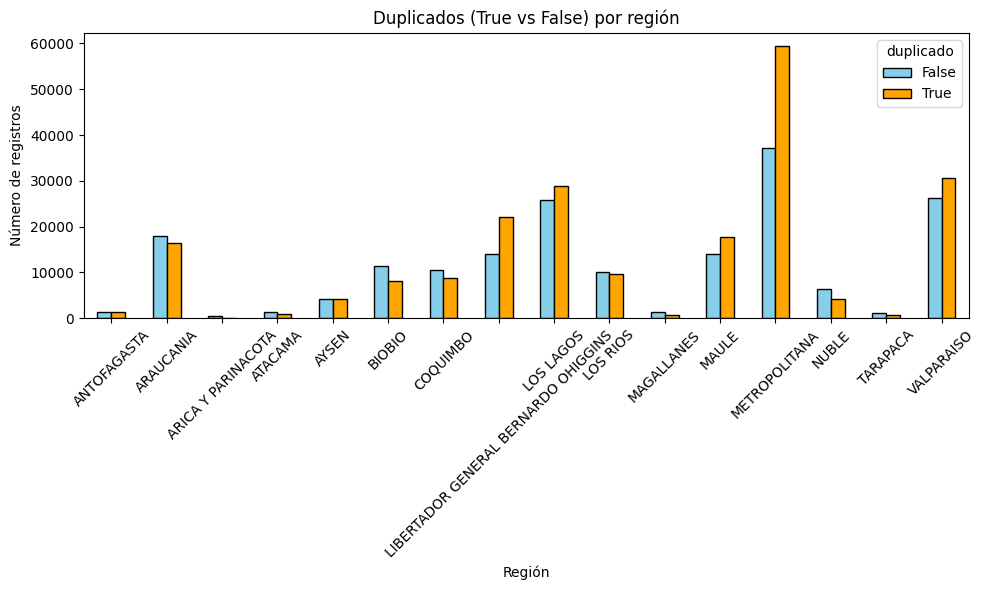

In [44]:
import matplotlib.pyplot as plt

# 1. Contar cuántos duplicados hay por región (True/False)
conteo_duplicados_region = data_lares.groupby(['region', 'duplicado']).size().unstack(fill_value=0)

# 2. Realizar el gráfico de barras agrupadas (True y False por región)
conteo_duplicados_region.plot(kind='bar', stacked=False, color=['skyblue', 'orange'], edgecolor='black', figsize=(10, 6))

# 3. Añadir etiquetas y título
plt.title('Duplicados (True vs False) por región')
plt.xlabel('Región')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)  # Rotar etiquetas de las regiones

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### Filtro por fecha y conteo de duplicados por región

In [1]:
import pandas as pd
data_lares  = pd.read_csv("data_lares_con_duplicados.csv")
# Convertimos la columna 'publicada' a formato de fecha
data_lares['publicada'] = pd.to_datetime(data_lares['publicada'])

# Filtramos los datos donde 'publicada' sea desde el 2021
data_2021 = data_lares[data_lares['publicada'].dt.year >= 2021]

# Contamos los valores TRUE y FALSE en 'duplicado' por 'region'
result = data_2021.groupby(['region', 'duplicado']).size().unstack(fill_value=0)
print(result)


duplicado                             False  True 
region                                            
ANTOFAGASTA                            1321   1267
ARAUCANIA                             18052  16539
ARICA Y PARINACOTA                      580    127
ATACAMA                                1305    991
AYSEN                                  4167   4114
BIOBIO                                11348   8209
COQUIMBO                              10597   8812
LIBERTADOR GENERAL BERNARDO OHIGGINS  14074  22088
LOS LAGOS                             25907  28903
LOS RIOS                              10064   9721
MAGALLANES                             1447    772
MAULE                                 14051  17674
METROPOLITANA                         37137  59337
NUBLE                                  6348   4148
TARAPACA                               1192    666
VALPARAISO                            26146  30674


### Contar filas unicas

In [100]:
!pip install networkx

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 1.3 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 4.2 MB/s eta 0:00:01
   -------------------- ------------------- 0.9/1.7 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 10.8 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 10.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
data_2021 = pd.read_csv('data_2021.csv')

In [3]:
# Contar cuántos 'False' hay en la columna 'duplicado'
total_false = data_2021[data_2021['duplicado'] == False].shape[0]
print(f"Total de valores False en 'duplicado': {total_false}")


Total de valores False en 'duplicado': 226937


In [4]:
import networkx as nx
import ast  # Para convertir las listas mal formateadas a listas reales

# Crear un grafo vacío
G = nx.Graph()

# Filtrar solo las filas que son duplicadas (duplicado == True)
data_duplicados = data_2021[data_2021['duplicado'] == True]

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']

    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Añadir nodos y conexiones entre el ID original y cada ID duplicado al grafo
                G.add_edge(row['id'], dup_id)

# Encontrar los grupos de nodos conectados (componentes conectadas)
grupos_duplicados = list(nx.connected_components(G))

# Contar el número total de grupos de duplicados
total_grupos_duplicados = len(grupos_duplicados)

# Mostrar el número total de grupos de duplicados
print(f"Total de grupos de duplicados: {total_grupos_duplicados}")



Total de grupos de duplicados: 52688


In [6]:
# Sumar el total de datos únicos a partir del conteo por región
total_datos_unicos = sum(conteo_por_region.values())

# Mostrar el total
print(f"Total de datos únicos: {total_datos_unicos}")


Total de datos únicos: 0


In [33]:
# Definir la lista de regiones y comunas
regiones_comunas = {
    "ARICA Y PARINACOTA": ["ARICA", "CAMARONES", "GENERAL LAGOS", "PUTRE"],
    "TARAPACA": ["ALTO HOSPICIO", "IQUIQUE", "HUARA", "CAMINA", "COLCHANE", "PICA", "POZO ALMONTE"],
    "ANTOFAGASTA": ["ANTOFAGASTA", "CALAMA", "MARIA ELENA", "MEJILLONES", "OLLAGUE", "SAN PEDRO DE ATACAMA", "SIERRA GORDA", "TALTAL", "TOCOPILLA"],
    "ATACAMA": ["ALTO DEL CARMEN", "CALDERA", "CHANARAL", "COPIAPO", "DIEGO DE ALMAGRO", "FREIRINA", "HUASCO", "TIERRA AMARILLA", "VALLENAR"],
    "COQUIMBO": ["ANDACOLLO", "CANELA", "COMBARBALA", "COQUIMBO", "ILLAPEL", "LA HIGUERA", "LA SERENA", "LOS VILOS", "MONTE PATRIA", "OVALLE", "PAIHUANO", "PUNITAQUI", "RIO HURTADO", "SALAMANCA", "VICUNA"],
    "VALPARAISO": ["ALGARROBO", "CABILDO", "CALLE LARGA", "CARTAGENA", "CASABLANCA", "CATEMU", "CONCON", "EL QUISCO", "EL TABO", "HIJUELAS", "ISLA DE PASCUA", "JUAN FERNANDEZ", "LA CALERA", "LA CRUZ", "LA LIGUA", "LIMACHE", "LLAILLAY", "LOS ANDES", "NOGALES", "OLMUE", "PANQUEHUE", "PAPUDO", "PETORCA", "PUCHUNCAVI", "PUTAENDO", "QUILLOTA", "QUILPUE", "QUINTERO", "RINCONADA", "SAN ANTONIO", "SAN ESTEBAN", "SAN FELIPE", "SANTA MARIA", "SANTO DOMINGO", "VALPARAISO", "VILLA ALEMANA", "VINA DEL MAR", "ZAPALLAR"],
    "METROPOLITANA": ["ALHUE", "BUIN", "CALERA DE TANGO", "CERRILLOS", "CERRO NAVIA", "COLINA", "CONCHALI", "CURACAVI", "EL BOSQUE", "EL MONTE", "ESTACION CENTRAL", "HUECHURABA", "INDEPENDENCIA", "ISLA DE MAIPO", "LA CISTERNA", "LA FLORIDA", "LA GRANJA", "LAMPA", "LA PINTANA", "LA REINA", "LAS CONDES", "LO BARNECHEA", "LO ESPEJO", "LO PRADO", "MACUL", "MAIPU", "MARIA PINTO", "MELIPILLA", "NUNOA", "PADRE HURTADO", "PAINE", "PEDRO AGUIRRE CERDA", "PENAFLOR", "PENALOLEN", "PIRQUE", "PROVIDENCIA", "PUDAHUEL", "PUENTE ALTO", "QUILICURA", "QUINTA NORMAL", "RECOLETA", "RENCA", "SAN BERNARDO", "SAN JOAQUIN", "SAN JOSE DE MAIPO", "SAN MIGUEL", "SAN PEDRO", "SAN RAMON", "SANTIAGO", "TALAGANTE", "TILTIL", "VITACURA"],
    "LIBERTADOR GENERAL BERNARDO OHIGGINS": ["CHEPICA", "CHIMBARONGO", "CODEGUA", "COINCO", "COLTAUCO", "DONIHUE", "GRANEROS", "LA ESTRELLA", "LAS CABRAS", "LITUECHE", "LOLOL", "MACHALI", "MALLOA", "MARCHIHUE", "MOSTAZAL", "NANCAGUA", "NAVIDAD", "OLIVAR", "PALMILLA", "PAREDONES", "PERALILLO", "PEUMO", "PICHIDEGUA", "PICHILEMU", "PLACILLA", "PUMANQUE", "QUINTA DE TILCOCO", "RANCAGUA", "RENGO", "REQUINOA", "SAN FERNANDO", "SANTA CRUZ", "SAN VICENTE"],
    "MAULE": ["CAUQUENES", "CHANCO", "COLBUN", "CONSTITUCION", "CUREPTO", "CURICO", "EMPEDRADO", "HUALANE", "LICANTEN", "LINARES", "LONGAVI", "MAULE", "MOLINA", "PARRAL", "PELARCO", "PELLUHUE", "PENCAHUE", "RAUCO", "RETIRO", "RIO CLARO", "ROMERAL", "SAGRADA FAMILIA", "SAN CLEMENTE", "SAN JAVIER", "SAN RAFAEL", "TALCA", "TENO", "VICHUQUEN", "VILLA ALEGRE", "YERBAS BUENAS"],
    "NUBLE": ["BULNES", "CHILLAN", "CHILLAN VIEJO", "COBQUECURA", "COELEMU", "COIHUECO", "EL CARMEN", "NINHUE", "NIQUEN", "PEMUCO", "PINTO", "PORTEZUELO", "QUILLON", "QUIRIHUE", "SAN CARLOS", "SAN FABIAN", "SAN IGNACIO", "SAN NICOLAS", "TREGUACO", "YUNGAY"],
    "BIOBIO": ["ALTO BIOBIO", "ANTUCO", "ARAUCO", "CABRERO", "CANETE", "CHIGUAYANTE", "CONCEPCION", "CONTULMO", "CORONEL", "CURANILAHUE", "FLORIDA", "HUALPEN", "HUALQUI", "LAJA", "LEBU", "LOS ALAMOS", "LOS ANGELES", "LOTA", "MULCHEN", "NACIMIENTO", "NEGRETE", "PENCO", "QUILACO", "QUILLECO", "SAN PEDRO DE LA PAZ", "SAN ROSENDO", "SANTA BARBARA", "SANTA JUANA", "TALCAHUANO", "TIRUA", "TOME", "TUCAPEL", "YUMBEL"],
    "ARAUCANIA": ["ANGOL", "CARAHUE", "CHOLCHOL", "COLLIPULLI", "CUNCO", "CURACAUTIN", "CURARREHUE", "ERCILLA", "FREIRE", "GALVARINO", "GORBEA", "LAUTARO", "LONCOCHE", "LONQUIMAY", "LOS SAUCES", "LUMACO", "MELIPEUCO", "NUEVA IMPERIAL", "PADRE LAS CASAS", "PERQUENCO", "PITRUFQUEN", "PUCON", "PUREN", "RENAICO", "SAAVEDRA", "TEMUCO", "TEODORO SCHMIDT", "TOLTEN", "TRAIGUEN", "VICTORIA", "VILCUN", "VILLARRICA"],
    "LOS RIOS": ["CORRAL", "FUTRONO", "LAGO RANCO", "LANCO", "LA UNION", "LOS LAGOS", "MAFIL", "MARIQUINA", "PAILLACO", "PANGUIPULLI", "RIO BUENO", "VALDIVIA"],
    "LOS LAGOS": ["ANCUD", "CALBUCO", "CASTRO", "CHAITEN", "CHONCHI", "COCHAMO", "CURACO DE VELEZ", "DALCAHUE", "FRESIA", "FRUTILLAR", "FUTALEUFU", "HUALAIHUE", "LLANQUIHUE", "LOS MUERMOS", "MAULLIN", "OSORNO", "PALENA", "PUERTO MONTT", "PUERTO OCTAY", "PUERTO VARAS", "PUQUELDON", "PURRANQUE", "PUYEHUE", "QUEILEN", "QUELLON", "QUEMCHI", "QUINCHAO", "RIO NEGRO", "SAN JUAN DE LA COSTA", "SAN PABLO"],
    "AYSEN": ["AYSEN", "CHILE CHICO", "CISNES", "COCHRANE", "COYHAIQUE", "GUAITECAS", "LAGO VERDE", "OHIGGINS", "RIO IBANEZ", "TORTEL"],
    "MAGALLANES": ["ANTARTICA", "CABO DE HORNOS", "LAGUNA BLANCA", "NATALES", "PORVENIR", "PRIMAVERA", "PUNTA ARENAS", "RIO VERDE", "SAN GREGORIO", "TIMAUKEL", "TORRES DEL PAINE"]
}

# Crear un diccionario para mapear las comunas a sus respectivas regiones
comunas_por_region = {}

# Iterar sobre el diccionario de regiones y comunas para construir el mapeo
for region, comunas in regiones_comunas.items():
    for comuna in comunas:
        comunas_por_region[comuna] = region

# Filtrar los datos que no tienen región
sin_region = data_2021[data_2021['region'].isna()]

# Iterar sobre las filas sin región y asignar la región según 'comuna_match'
for idx, row in sin_region.iterrows():
    comuna = row['comuna_match'].upper()  # Asegurarnos de que coincidan en mayúsculas
    if comuna in comunas_por_region:
        # Asignar la región según el diccionario de comunas
        data_2021.loc[idx, 'region'] = comunas_por_region[comuna]

# Verificar cuántas filas todavía no tienen región después del proceso
sin_region_actualizado = data_2021[data_2021['region'].isna()]
print(f"Total de filas que aún no tienen región: {sin_region_actualizado.shape[0]}")

# (Opcional) Guardar los datos actualizados si es necesario
data_2021.to_csv('data_2021.csv', index=False)

Total de filas que aún no tienen región: 0


In [5]:
# Crear un diccionario para contar los datos únicos por región
conteo_por_region = {}

# 1. Contar los nodos principales de cada grupo de duplicados
for grupo in grupos_duplicados:
    # Para cada grupo, tomar un único nodo del grupo (ID principal)
    id_principal = list(grupo)[0]
    
    # Verificar la región del nodo principal
    region = data_2021.loc[data_2021['id'] == id_principal, 'region'].values[0]
    
    # Incrementar el conteo para esa región
    if region in conteo_por_region:
        conteo_por_region[region] += 1
    else:
        conteo_por_region[region] = 1

# 2. Contar los datos que no están duplicados (FALSE en 'duplicado')
ids_sin_duplicados = data_2021[data_2021['duplicado'] == False]

for idx, row in ids_sin_duplicados.iterrows():
    region = row['region']
    
    # Incrementar el conteo para esa región
    if region in conteo_por_region:
        conteo_por_region[region] += 1
    else:
        conteo_por_region[region] = 1

# Convertir el conteo a un DataFrame para visualizar
conteo_por_region_df = pd.DataFrame(list(conteo_por_region.items()), columns=['Region', 'Datos Unicos'])

# Mostrar la tabla
print(conteo_por_region_df)



                                  Region  Datos Unicos
0   LIBERTADOR GENERAL BERNARDO OHIGGINS         20957
1                                  MAULE         20050
2                          METROPOLITANA         64128
3                             VALPARAISO         42003
4                                ATACAMA          2208
5                                  NUBLE          8479
6                               LOS RIOS         15404
7                               COQUIMBO         14999
8                                 BIOBIO         15411
9                              LOS LAGOS         37237
10                                 AYSEN          5985
11                           ANTOFAGASTA          2896
12                             ARAUCANIA         25768
13                    ARICA Y PARINACOTA           680
14                              TARAPACA          1590
15                            MAGALLANES          1830


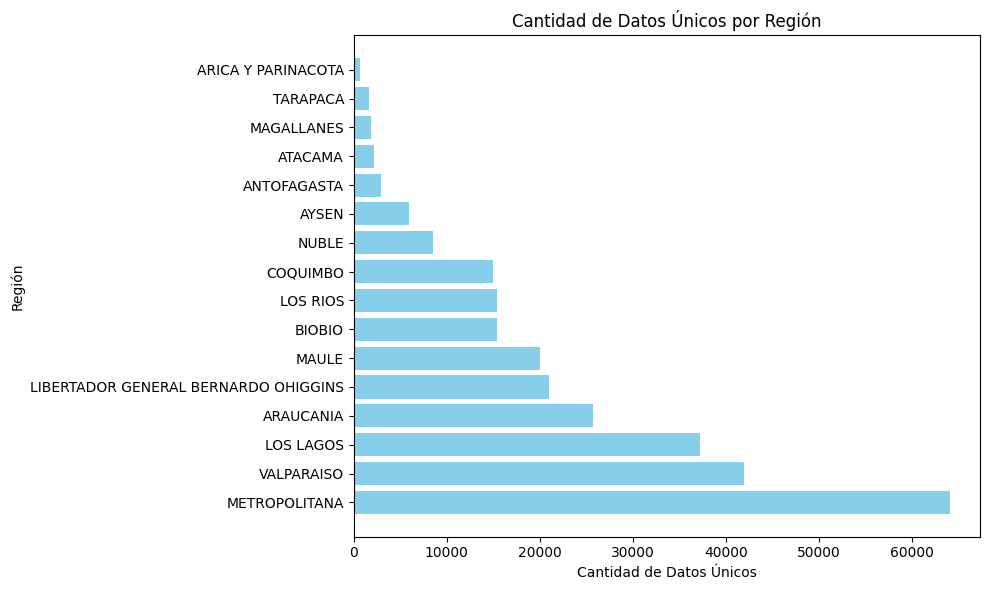

In [43]:
import matplotlib.pyplot as plt

# Establecer el fondo del gráfico a blanco
plt.style.use('default')

# Ordenar los datos por cantidad de datos únicos
conteo_por_region_df = conteo_por_region_df.sort_values(by='Datos Unicos', ascending=False)

# Crear un gráfico de barras para los datos únicos por región
plt.figure(figsize=(10, 6))

# Graficar
plt.barh(conteo_por_region_df['Region'], conteo_por_region_df['Datos Unicos'], color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Cantidad de Datos Únicos')
plt.ylabel('Región')
plt.title('Cantidad de Datos Únicos por Región')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### Datos sin descripción o con descipción "el vendedor no incluyó una descripción del inmueble"

In [6]:
# Filtrar la data donde 'descripcion_normalizada' está vacía o coincide con el texto específico
filtro_descripcion = data_2021[
    (data_2021['descripcion_normalizada'].isna()) | 
    (data_2021['descripcion_normalizada'] == 'el vendedor no incluyó una descripción del inmueble')
]

# Mostrar los resultados del filtro
print(filtro_descripcion)

             id                                             concat  \
3           325  https://www.portalinmobiliario.com/MLC-2134217...   
9          4337  https://www.portalinmobiliario.com/venta/sitio...   
19        11783  https://www.portalinmobiliario.com/MLC-9370028...   
32        12477  https://www.portalinmobiliario.com/venta/sitio...   
38        12720  https://www.portalinmobiliario.com/MLC-9369953...   
...         ...                                                ...   
440880  8031784  https://www.portalinmobiliario.com/MLC-1510920...   
440881  8031785  https://www.portalinmobiliario.com/MLC-2638886...   
440882  8031786  https://www.portalinmobiliario.com/MLC-1510841...   
440883  8031787  https://www.portalinmobiliario.com/MLC-1510912...   
440884  8031788  https://www.portalinmobiliario.com/MLC-1510859...   

         publicada  created_at         data_source     tipo sub_tipo  \
3       2023-11-02  2020-07-07  Portalinmobiliario  Terreno  Terreno   
9       2021-09

### Detecta si son duplicados por la distancia entre los datos

In [11]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Filtrar los datos sin descripción o con la descripción 'el vendedor no incluyó una descripción del inmueble'
filtro_descripcion = data_2021[
    (data_2021['descripcion_normalizada'].isna()) | 
    (data_2021['descripcion_normalizada'] == 'el vendedor no incluyó una descripción del inmueble')
].copy()

# Resetear las columnas 'duplicados_con' y 'duplicado'
filtro_descripcion['duplicados_con'] = [[] for _ in range(len(filtro_descripcion))]
filtro_descripcion['duplicado'] = False  # Reiniciar como False

# Iterar sobre cada región y semestre en el conjunto filtrado
for region, grupo_region in filtro_descripcion.groupby('region'):
    for semestre, grupo_semestre in grupo_region.groupby('semestre'):
        # Mostrar el progreso actual
        print(f"Procesando {semestre} región {region}...")

        # Filtrar filas con coordenadas válidas (latitud y longitud no iguales a 0)
        grupo_semestre = grupo_semestre[(grupo_semestre['latitude'] != 0) & (grupo_semestre['longitude'] != 0)]

        # Solo proceder si hay al menos 2 filas en el grupo después del filtrado
        if len(grupo_semestre) < 2:
            print(f"Omitido {semestre} región {region} (menos de 2 propiedades con coordenadas válidas)")
            continue

        # Crear una matriz de latitud y longitud
        coordenadas = grupo_semestre[['latitude', 'longitude']].to_numpy()

        # Calcular la matriz de distancias (distancia euclidiana aproximada para lat/lon)
        distancias = pairwise_distances(coordenadas, metric='euclidean')

        # Convertir la distancia en metros (asumiendo que la distancia euclidiana está en grados)
        distancias_metros = distancias * 111000  # Convertimos a metros

        # Definir el umbral de 150 metros para marcar duplicados
        umbral_distancia = 150

        # Iterar sobre la matriz de distancias y marcar duplicados
        for i in range(distancias_metros.shape[0]):
            for j in range(i + 1, distancias_metros.shape[1]):
                if distancias_metros[i, j] < umbral_distancia:
                    id_1 = grupo_semestre.iloc[i]['id']
                    id_2 = grupo_semestre.iloc[j]['id']
                    
                    # Añadir a la lista de duplicados
                    if id_2 not in grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[i], 'duplicados_con'].append(id_2)
                    if id_1 not in grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con']:
                        grupo_semestre.at[grupo_semestre.index[j], 'duplicados_con'].append(id_1)

        # Actualizar el DataFrame principal con los duplicados encontrados
        filtro_descripcion.update(grupo_semestre)

        # Indicar que se ha terminado de procesar la región y el semestre
        print(f"Procesado completado para {semestre} región {region}")

# Eliminar duplicados en las listas de duplicados
filtro_descripcion['duplicados_con'] = filtro_descripcion['duplicados_con'].apply(lambda x: list(set(x)))

# Marcar los registros duplicados en la columna 'duplicado'
filtro_descripcion['duplicado'] = filtro_descripcion['duplicados_con'].apply(lambda x: len(x) > 0)

# Mostrar cuántos duplicados se encontraron
print(f"Duplicados encontrados en la data sin descripción: {filtro_descripcion['duplicado'].sum()}")




Procesando 2021S1 región ANTOFAGASTA...
Omitido 2021S1 región ANTOFAGASTA (menos de 2 propiedades con coordenadas válidas)
Procesando 2021S2 región ANTOFAGASTA...
Procesado completado para 2021S2 región ANTOFAGASTA
Procesando 2022S1 región ANTOFAGASTA...
Procesado completado para 2022S1 región ANTOFAGASTA
Procesando 2022S2 región ANTOFAGASTA...
Procesado completado para 2022S2 región ANTOFAGASTA
Procesando 2023S1 región ANTOFAGASTA...
Procesado completado para 2023S1 región ANTOFAGASTA
Procesando 2023S2 región ANTOFAGASTA...
Procesado completado para 2023S2 región ANTOFAGASTA
Procesando 2024S1 región ANTOFAGASTA...
Procesado completado para 2024S1 región ANTOFAGASTA
Procesando 2024S2 región ANTOFAGASTA...
Procesado completado para 2024S2 región ANTOFAGASTA
Procesando 2021S1 región ARAUCANIA...
Procesado completado para 2021S1 región ARAUCANIA
Procesando 2021S2 región ARAUCANIA...
Procesado completado para 2021S2 región ARAUCANIA
Procesando 2022S1 región ARAUCANIA...
Procesado completad

In [12]:
# Contar el número de filas en el DataFrame 'filtro_descripcion'
cantidad_datos = filtro_descripcion.shape[0]

# Mostrar la cantidad de datos
print(f"Cantidad de datos filtrados: {cantidad_datos}")
filtro_descripcion.to_csv("data_sin_descripcion_duplicados.csv", index=False)

Cantidad de datos filtrados: 46125


In [13]:
import networkx as nx
import ast  # Para convertir las listas mal formateadas a listas reales

# Crear un grafo vacío
G = nx.Graph()

# Contar cuántos TRUE y FALSE hay en la columna 'duplicado' en el DataFrame filtrado (filtro_descripcion)
total_true = filtro_descripcion['duplicado'].sum()  # Suma los valores TRUE (True se cuenta como 1)
total_false = len(filtro_descripcion) - total_true  # Total menos los TRUE es igual a los FALSE

# Filtrar solo las filas que son duplicadas (duplicado == True) en filtro_descripcion
data_duplicados = filtro_descripcion[filtro_descripcion['duplicado'] == True]

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']

    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Añadir nodos y conexiones entre el ID original y cada ID duplicado al grafo
                G.add_edge(row['id'], dup_id)

# Encontrar los grupos de nodos conectados (componentes conectadas)
grupos_duplicados = list(nx.connected_components(G))

# Contar el número total de grupos de duplicados
total_grupos_duplicados = len(grupos_duplicados)

# Mostrar el número total de grupos de duplicados y cuántos TRUE/FALSE hay
print(f"Total de grupos de duplicados: {total_grupos_duplicados}")
print(f"Total de TRUE en 'duplicado' en filtro_descripcion: {total_true}")
print(f"Total de FALSE en 'duplicado' en filtro_descripcion: {total_false}")


Total de grupos de duplicados: 4657
Total de TRUE en 'duplicado' en filtro_descripcion: 17345
Total de FALSE en 'duplicado' en filtro_descripcion: 28780


In [14]:
# Guardar el DataFrame filtrado con los duplicados identificados
filtro_descripcion.to_csv("data_sin_descripcion_duplicados.csv", index=False)

### Actualizar filas identificadas

In [15]:
# Actualizamos las columnas en 'data_2021' con los datos de 'filtro_descripcion' en base a 'id'

# Primero hacemos un merge entre 'data_2021' y 'filtro_descripcion' basándonos en 'id'
# Esto asegura que estamos actualizando solo las filas que coinciden en 'id'
data_actualizada = data_2021.set_index('id').combine_first(filtro_descripcion.set_index('id')).reset_index()

data_2021 = data_actualizada
# Guardar la data actualizada si lo deseas
data_2021.to_csv("data_2021_actualizada.csv", index=False)




### Consolidar filas duplicadas

In [ ]:
# Filtrar solo las filas que son duplicadas (duplicado == True)
data_duplicados = data_2021[data_2021['duplicado'] == True]

### Contaremos cuantos grupos hay de duplicados en total

In [16]:
import networkx as nx
import ast  # Para convertir las listas mal formateadas a listas reales

# Filtrar solo las filas que son duplicadas (duplicado == True) en data_2021
data_duplicados = data_2021[data_2021['duplicado'] == True]

# Crear un grafo vacío
G = nx.Graph()

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']

    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Añadir nodos y conexiones entre el ID original y cada ID duplicado al grafo
                G.add_edge(row['id'], dup_id)

# Encontrar los grupos de nodos conectados (componentes conectadas)
grupos_duplicados = list(nx.connected_components(G))

# Contar el número total de grupos de duplicados
total_grupos_duplicados = len(grupos_duplicados)

# Mostrar el número total de grupos de duplicados
print(f"Total de grupos de duplicados: {total_grupos_duplicados}")

# Si quieres verificar cuántos TRUE y FALSE hay en 'duplicado' en data_2021
total_true = data_2021['duplicado'].sum()  # Suma los valores TRUE
total_false = len(data_2021) - total_true  # El total menos los TRUE es igual a los FALSE

print(f"Total de TRUE en 'duplicado' en data_2021: {total_true}")
print(f"Total de FALSE en 'duplicado' en data_2021: {total_false}")


Total de grupos de duplicados: 52688
Total de TRUE en 'duplicado' en data_2021: 214042
Total de FALSE en 'duplicado' en data_2021: 226937


## Crear columnas con el valor UF e identificación si estan dentro del margen [27000;39000]

In [18]:
# Crear columna 'valor_uf_inicial' dividiendo 'precio_clp_inicial' entre 'precio_uf_inicial'
data_2021['valor_uf_inicial'] = data_2021['precio_clp_inicial'] / data_2021['precio_uf_inicial']

# Crear columna 'valor_uf' dividiendo 'precio_clp' entre 'precio_uf'
data_2021['valor_uf'] = data_2021['precio_clp'] / data_2021['precio_uf']

# Crear columna 'margen_uf_inicial' que pone 1 si 'valor_uf_inicial' está dentro del rango [27000, 39000], 0 si no
data_2021['margen_uf_inicial'] = data_2021['valor_uf_inicial'].apply(lambda x: 1 if 27000 <= x <= 39000 else 0)

# Crear columna 'margen_uf' que pone 1 si 'valor_uf' está dentro del rango [27000, 39000], 0 si no
data_2021['margen_uf'] = data_2021['valor_uf'].apply(lambda x: 1 if 27000 <= x <= 39000 else 0)

data_2021.to_csv("data_2021.csv", index=False)


## Actualizar superficies y eliminar data sin superficie

### Seleccionar información de data duplicada

In [21]:
import pandas as pd
# Crear un DataFrame para almacenar las filas eliminadas
filas_eliminadas = pd.DataFrame(columns=data_2021.columns)

# Iterar sobre cada fila para aplicar los criterios
for idx, row in data_2021.iterrows():
    total = row['total_o_terreno']
    mayor = row['mayor_superficie']
    dif_pct_abs = row['dif_pct_abs']
    
    # 1. Si 'total_o_terreno' != 0 y 'mayor_superficie' es NaN, dejamos 'total_o_terreno' como está
    if total != 0 and pd.isna(mayor):
        continue
    
    # 2. Si 'total_o_terreno' es 0 y 'mayor_superficie' no es NaN, asignamos el valor de 'mayor_superficie' a 'total_o_terreno'
    elif total == 0 and not pd.isna(mayor):
        data_2021.at[idx, 'total_o_terreno'] = mayor
    
    # 3. Si 'total_o_terreno' != 0 y 'mayor_superficie' tampoco es NaN, aplicamos las reglas según 'dif_pct_abs'
    elif total != 0 and not pd.isna(mayor):
        # Si 'dif_pct_abs' == 100 o 50, dejamos 'total_o_terreno' sin cambios
        if dif_pct_abs == 100 or dif_pct_abs == 50:
            continue
        # Si 'dif_pct_abs' es menor que 100, reemplazamos 'total_o_terreno' por 'mayor_superficie'
        elif dif_pct_abs < 100:
            data_2021.at[idx, 'total_o_terreno'] = mayor
        # Si 'dif_pct_abs' es mayor que 100, también reemplazamos 'total_o_terreno' por 'mayor_superficie'
        elif dif_pct_abs > 100:
            data_2021.at[idx, 'total_o_terreno'] = mayor
    
    # 4. Si ambos 'total_o_terreno' y 'mayor_superficie' son 0 o NaN, eliminamos la fila (la guardamos primero)
    if (total == 0 or pd.isna(total)) and (mayor == 0 or pd.isna(mayor)):
        # Agregar la fila al DataFrame de filas eliminadas
        filas_eliminadas = pd.concat([filas_eliminadas, pd.DataFrame([row])], ignore_index=True)
        # Marcar la fila para eliminación
        data_2021.at[idx, 'to_delete'] = True

# Eliminar las filas que fueron marcadas para eliminación
data_2021_limpia = data_2021[data_2021['to_delete'].isna()].drop(columns=['to_delete'])

# Guardar las filas eliminadas para revisión
filas_eliminadas.to_csv("filas_eliminadas_terreno.csv", index=False)

# Guardar el DataFrame limpio (sin las filas eliminadas)
data_2021_limpia.to_csv("data_2021_liimpia.csv", index=False)

# Verificar los resultados
print(f"Total de filas eliminadas: {len(filas_eliminadas)}")
print(f"Total de filas en la data actualizada: {len(data_2021_limpia)}")


C:\Users\franc\AppData\Local\Temp\ipykernel_10120\2686453915.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filas_eliminadas = pd.concat([filas_eliminadas, pd.DataFrame([row])], ignore_index=True)
C:\Users\franc\AppData\Local\Temp\ipykernel_10120\2686453915.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '889.23' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_2021.at[idx, 'total_o_terreno'] = mayor


Total de filas eliminadas: 46669
Total de filas en la data actualizada: 394310


In [23]:
data_2021 = data_2021_limpia

In [25]:
import networkx as nx
import ast  # Para convertir las listas mal formateadas a listas reales

# Filtrar solo las filas que son duplicadas (duplicado == True) en data_2021
data_duplicados = data_2021[data_2021['duplicado'] == True]

# Crear un grafo vacío
G = nx.Graph()

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']

    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Añadir nodos y conexiones entre el ID original y cada ID duplicado al grafo
                G.add_edge(row['id'], dup_id)

# Encontrar los grupos de nodos conectados (componentes conectadas)
grupos_duplicados = list(nx.connected_components(G))

# Contar el número total de grupos de duplicados
total_grupos_duplicados = len(grupos_duplicados)

# Mostrar el número total de grupos de duplicados
print(f"Total de grupos de duplicados: {total_grupos_duplicados}")

# Si quieres verificar cuántos TRUE y FALSE hay en 'duplicado' en data_2021
total_true = data_2021['duplicado'].sum()  # Suma los valores TRUE
total_false = len(data_2021) - total_true  # El total menos los TRUE es igual a los FALSE

print(f"Total de TRUE en 'duplicado' en data_2021: {total_true}")
print(f"Total de FALSE en 'duplicado' en data_2021: {total_false}")


Total de grupos de duplicados: 51751
Total de TRUE en 'duplicado' en data_2021: 206194
Total de FALSE en 'duplicado' en data_2021: 188116


## Consolidación de filas duplicadas

In [26]:
import pandas as pd
import numpy as np

# 1. Filtrar solo las filas que son duplicadas (duplicado == True)
data_duplicados = data_2021[data_2021['duplicado'] == True].copy()

# Crear un DataFrame para almacenar las filas "completadas" (una fila por grupo de duplicados)
data_completa = pd.DataFrame(columns=data_duplicados.columns)

# 2. Iterar sobre los grupos de duplicados
for grupo in grupos_duplicados:
    # Convertir el grupo en una lista de IDs
    ids_grupo = list(grupo)
    
    # Obtener las filas del DataFrame original que pertenecen a este grupo
    filas_grupo = data_duplicados[data_duplicados['id'].isin(ids_grupo)].copy()

    # 3. Ordenar las filas según los criterios:
    # 1. Menor cantidad de NaN
    # 2. Fecha más reciente dentro del semestre ('publicada')
    # 3. Priorizar donde 'margen_uf_inicial' o 'margen_uf' == 1
    # 4. Priorizar donde 'data_source' == 'Portalinmobiliario'
    
    filas_grupo['na_count'] = filas_grupo.isna().sum(axis=1)
    
    filas_grupo = filas_grupo.sort_values(
        by=['na_count', 'publicada', 'margen_uf_inicial', 'margen_uf', 'data_source'],
        ascending=[True, False, False, False, False]
    )

    # Seleccionar la fila principal que ahora es la primera después del ordenamiento
    fila_principal = filas_grupo.iloc[0].copy()
    
    # Iterar sobre las demás filas del grupo para completar la información faltante
    for _, fila in filas_grupo.iterrows():
        for columna in data_duplicados.columns:
            # Si el valor de la columna en la fila principal es NaN, intenta rellenarlo
            if pd.isna(fila_principal[columna]):
                fila_principal[columna] = fila[columna]
    
    # Añadir la fila "completada" al nuevo DataFrame usando pd.concat
    data_completa = pd.concat([data_completa, pd.DataFrame([fila_principal])], ignore_index=True)

# Eliminar la columna auxiliar 'na_count'
data_completa.drop(columns=['na_count'], inplace=True)

# 4. Ahora combinamos data_completa con las filas que no son duplicados
data_no_duplicados = data_2021[data_2021['duplicado'] == False]

# Combinar las filas no duplicadas con las filas completadas de duplicados
data_final = pd.concat([data_no_duplicados, data_completa], ignore_index=True)

# 5. Guardar el DataFrame final con solo una fila por grupo de duplicados y las filas no duplicadas
data_final.to_csv("data_2021_final.csv", index=False)

# Verificar los resultados
print("Proceso de selección de filas principales por grupos de duplicados finalizado.")
print(f"Total de filas finales: {len(data_final)}")



C:\Users\franc\AppData\Local\Temp\ipykernel_10120\1686586763.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_completa = pd.concat([data_completa, pd.DataFrame([fila_principal])], ignore_index=True)


Proceso de selección de filas principales por grupos de duplicados finalizado.
Total de filas finales: 239867


In [28]:
datos = data_final[data_final['total_o_terreno'] != 0]
print(f"Total de filas finales: {len(datos)}")

Total de filas finales: 239867



### Visualización con una muestra pequeña para entender que es lo que hace

In [112]:
import numpy as np
import ast  # Para convertir las listas mal formateadas a listas reales

# Filtrar solo las filas que son duplicadas (duplicado == True)
data_duplicados = data_lares[data_lares['duplicado'] == True]

# Crear una lista para almacenar las conexiones entre nodos
conexiones = []

# Iterar sobre cada fila y su lista de duplicados en la columna 'duplicados_con'
for idx, row in data_duplicados.iterrows():
    # Convertir la cadena de duplicados a una lista usando ast.literal_eval si es necesario
    if isinstance(row['duplicados_con'], str):
        try:
            duplicados_list = ast.literal_eval(row['duplicados_con'])  # Convertir a lista real
        except (ValueError, SyntaxError):
            duplicados_list = []  # Si no se puede convertir, asumir que está vacía
    else:
        duplicados_list = row['duplicados_con']
    
    # Iterar sobre los duplicados si existen
    if len(duplicados_list) > 0:
        for dup_id in duplicados_list:
            # Evitar errores con valores no válidos
            if dup_id:
                # Agregar la conexión como un par de (ID original, ID duplicado)
                conexiones.append((row['id'], dup_id))

# Crear un DataFrame para mostrar las conexiones como una tabla
df_conexiones = pd.DataFrame(conexiones, columns=['ID Nodo Original', 'ID Nodo Duplicado'])

# Muestrear una cantidad de nodos específicos para graficar
num_muestra = 50  # Ajusta este valor según el tamaño de la muestra que quieras visualizar

# Fijar la semilla para asegurar reproducibilidad en el muestreo
np.random.seed(42)

# Seleccionar aleatoriamente nodos para la muestra
nodos_muestra = df_conexiones['ID Nodo Original'].drop_duplicates().sample(n=num_muestra)

# Filtrar las conexiones para que solo muestren los nodos que están en la muestra
df_conexiones_muestra = df_conexiones[df_conexiones['ID Nodo Original'].isin(nodos_muestra)]

# Mostrar las primeras filas de la tabla con las conexiones de la muestra
print("Conexiones entre nodos duplicados (muestra de 50 nodos):")
print(df_conexiones_muestra.head(50))  # Mostrar solo las primeras 50 conexiones para visualizar mejor




Conexiones entre nodos duplicados (muestra de 50 nodos):
        ID Nodo Original  ID Nodo Duplicado
51533            1318453             152110
93892            1502936            1541055
98607            1522912            1475680
98608            1522912            1483334
98609            1522912            1543100
98610            1522912            1460942
98611            1522912            1411761
98612            1522912            1417779
98613            1522912            1530101
98614            1522912            1557654
98615            1522912            1531736
98616            1522912            1439804
162893           1657431            1684359
162894           1657431            2045192
162895           1657431            1749389
162896           1657431            2168600
162897           1657431            1711133
162898           1657431            2099232
162899           1657431            2122788
162900           1657431            1988138
162901           16